# Training Analysis

In [2]:
import os
import sys
from tqdm import tqdm
import natsort
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import seaborn as sns
import cv2
import plotly.express as px
import plotly.graph_objects as go
from loguru import logger
from PIL import Image

from data.loader import define_loaders
from utils.utils import load_config
from utils.torch import load_model_weights
from model_zoo.models import define_model
from utils.plot import plot_metrics, plot_training_loss
from data.dataset import Sentinel2Dataset, read_images
from training.metrics import MultiSpectralMetrics
from post_training.post_training import (generate_exp_paths,prepare_paths, prepare_data,
                                         evaluate_and_plot, calculate_valid_pixel_percentages,
                                         plot_3d_scatter)


/home/ubuntu/miniconda3/envs/ai_processor/lib/python3.12/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
path = "/home/ubuntu/project/sentinel-2-ai-processor/src/results/2025-04-29_16-34-20"
exp_paths = generate_exp_paths(exp_path=path)
config = load_config(config_path=f"{exp_paths['result_dir']}/config.yaml")

In [4]:
version = config['DATASET']['version']
bands = config['DATASET']['bands']
resize = config['TRAINING']['resize']
num_workers = config['TRAINING']['num_workers']

df_loss = pd.read_csv(f"{exp_paths['metrics_path']}/losses.csv")
df_ssim = pd.read_csv(f"{exp_paths['metrics_path']}/ssim_metrics.csv")
df_sam = pd.read_csv(f"{exp_paths['metrics_path']}/sam_metrics.csv")
df_rmse = pd.read_csv(f"{exp_paths['metrics_path']}/rmse_metrics.csv")
df_psnr = pd.read_csv(f"{exp_paths['metrics_path']}/psnr_metrics.csv")

In [5]:
# # Plot all metrics
# metrics = {
#     "PSNR": df_psnr,
#     "SSIM": df_ssim,
#     "SAM": df_sam,
#     "RMSE": df_rmse
# }
# for title, df_metric in metrics.items():
#     plot_metrics(df_metric, bands=bands, title=f"{title} Evolution During Training - Dataset {version}",
#                 log_scale=False, y_label=title, verbose=False, save=True,
#                 save_path=exp_paths['metrics_path'], color_palette="plasma")

In [6]:
# plot_training_loss(df=df_loss,
#                     title="Training and Validation Loss",
#                     y_label="Loss",
#                     log_scale=False,
#                     verbose=True,
#                     save=True,
#                     save_path=mertrics_dir,
#                     color_palette="plasma"
#                     )

## Load Config

In [9]:
# Load test data
test_dir = f"/mnt/disk/dataset/sentinel-ai-processor/{version}/test/"
df_test_input, df_test_output = prepare_paths(test_dir)
df_test_input = df_test_input[0:16]
df_test_output = df_test_output[0:16]

In [10]:
df_test_output = calculate_valid_pixel_percentages(df=df_test_output, column_name="path", show_progress=True)
test_dataset = Sentinel2Dataset(df_x=df_test_input, df_y=df_test_output, train=True, augmentation=False, img_size=resize)
test_loader = define_loaders(
    train_dataset=test_dataset,
    val_dataset=None,
    train=False,
    batch_size=1,
    num_workers=num_workers
)

Processing Valid Pixel: 100%|███████████████████████████████████████| 16/16 [00:00<00:00, 16.17it/s]


In [24]:
df_test_output_w = df_test_output.copy()

## Load Model 

In [17]:
weights_path = f"{exp_paths['checkpoint_path']}/best_model.pth"
model = define_model(name=config["MODEL"]["model_name"],
                    encoder_name=config["MODEL"]["encoder_name"],
                    in_channel=len(bands),
                    out_channels=len(bands),
                    activation=config["MODEL"]["activation"])

# Load best model weights
model = load_model_weights(model=model, filename=weights_path)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

2025-04-30 12:42:04.790 | INFO     | utils.torch:load_model_weights:103 - 
 -> Loading encoder weights from /home/ubuntu/project/sentinel-2-ai-processor/src/results/2025-04-29_16-34-20/checkpoints/best_model.pth



## Test Dataset inference

In [14]:
def valid_pixel_ratio_t(tensor):
    """
    Calculate the ratio of valid (non-zero) pixels in a PyTorch tensor.

    Parameters:
    -----------
    tensor : torch.Tensor
        The input tensor representing image data, expected shape [B, C, H, W].

    Returns:
    --------
    torch.Tensor
        The ratio of pixels with values greater than zero to the total number of pixels.
        Returns a scalar tensor.
    """
    # Get total number of pixels (across all batch items, channels, and spatial dimensions)
    total_pixels = tensor.numel()

    # Count valid pixels (values > 0)
    valid_pixel_number = torch.sum(tensor > 0).item()

    # Calculate ratio
    ratio = valid_pixel_number / total_pixels

    return ratio

In [28]:
test_metrics_tracker = MultiSpectralMetrics(bands=bands, device=device)

# Prepare the dictionary to store per-band metrics
metrics_dict = {}
for band in test_metrics_tracker.bands:
    for metric_name in ['psnr', 'rmse', 'ssim', 'sam']:
        metrics_dict[f"{metric_name}_{band}"] = []
metrics_dict['valid_pixel'] = []

# Reset tracker
test_metrics_tracker.reset()
# Model evaluation
model.eval()
with torch.no_grad():
    with tqdm(total=len(test_loader.dataset), ncols=100, colour='#cc99ff') as t:

        for x_data, y_data in test_loader:
            x_data, y_data = x_data.to(device), y_data.to(device)
            outputs = model(x_data)

            # Reset tracker for individual image
            test_metrics_tracker.reset()
            test_metrics_tracker.update(outputs, y_data)
            metrics = test_metrics_tracker.compute()

            # Calculate valid pixel ratios for each band
            band_ratios = []
            for i, band in enumerate(test_metrics_tracker.bands):
                valid_ratio = valid_pixel_ratio_t(y_data[0, i, :, :])

                band_ratios.append(valid_ratio)

            # Store the mean ratio
            mean_ratio = sum(band_ratios) / len(band_ratios)
            metrics_dict['valid_pixel'].append(mean_ratio)

            # Calculate weights from ratios
            band_weights = [np.sqrt(ratio) for ratio in band_ratios]

            # Store per-band metrics
            for i, band in enumerate(test_metrics_tracker.bands):
                band_weight = band_weights[i]
                for metric_name in ['psnr', 'rmse', 'ssim', 'sam']:
                    # Apply weight only to SAM metric
                    if metric_name == 'sam':
                        value = metrics[band][metric_name] * band_weight
                    else:
                        value = metrics[band][metric_name]
                    metrics_dict[f"{metric_name}_{band}"].append(value)

            t.update(x_data.size(0))

# After the loop, merge the metrics into the original dataframe
for column_name, values in metrics_dict.items():
    df_test_output_w[column_name] = values

100%|███████████████████████████████████████████████████████████████| 16/16 [00:03<00:00,  4.29it/s]


In [26]:
test_metrics_tracker = MultiSpectralMetrics(bands=bands, device=device)

# Prepare the dictionary to store per-band metrics
metrics_dict = {}
for band in test_metrics_tracker.bands:
    for metric_name in ['psnr', 'rmse', 'ssim', 'sam']:
        metrics_dict[f"{metric_name}_{band}"] = []

# Reset tracker
test_metrics_tracker.reset()

# Model evaluation
model.eval()
with torch.no_grad():
    with tqdm(total=len(test_loader.dataset), ncols=100, colour='#cc99ff') as t:

        for x_data, y_data in test_loader:
            x_data, y_data = x_data.to(device), y_data.to(device)
            outputs = model(x_data)
            # Reset tracker for individual image
            test_metrics_tracker.reset()
            test_metrics_tracker.update(outputs, y_data)
            metrics = test_metrics_tracker.compute()
            # Store per-band metrics
            for band in test_metrics_tracker.bands:
                for metric_name in ['psnr', 'rmse', 'ssim', 'sam']:
                    value = metrics[band][metric_name]
                    metrics_dict[f"{metric_name}_{band}"].append(value)

            t.update(x_data.size(0))

# After the loop, merge the metrics into the original dataframe
for column_name, values in metrics_dict.items():
    df_test_output[column_name] = values

100%|███████████████████████████████████████████████████████████████| 16/16 [00:03<00:00,  5.10it/s]


In [27]:
df_test_output_w

,id_key,Name,S3Path,Footprint,GeoFootprint,cloud_cover,path,valid_pixel,psnr_B02,rmse_B02,ssim_B02,sam_B02,psnr_B03,rmse_B03,ssim_B03,sam_B03,psnr_B04,rmse_B04,ssim_B04,sam_B04
0,S2A_MSIL1C_20180105T103421_N0500_R108_T32TMT,S2A_MSIL2A_20180105T103421_N0500_R108_T32TMT_2...,/eodata/Sentinel-2/MSI/L2A_N0500/2018/01/05/S2...,geography'SRID=4326;POLYGON ((7.66286529044567...,"{'type': 'Polygon', 'coordinates': [[[7.662865...",76.968253,/mnt/disk/dataset/sentinel-ai-processor/V2/tes...,0.991851,40.083633,0.009904,0.983729,0.022122,41.272964,0.008637,0.990179,0.017277,39.819164,0.010210,0.987253,0.022180
1,S2B_MSIL1C_20180107T102359_N0500_R065_T32TPS,S2B_MSIL2A_20180107T102359_N0500_R065_T32TPS_2...,/eodata/Sentinel-2/MSI/L2A_N0500/2018/01/07/S2...,geography'SRID=4326;POLYGON ((11.7513728834118...,"{'type': 'Polygon', 'coordinates': [[[11.75137...",96.654195,/mnt/disk/dataset/sentinel-ai-processor/V2/tes...,0.880229,40.662964,0.009265,0.992336,0.017675,41.318455,0.008592,0.994873,0.014659,40.209282,0.009762,0.993706,0.018788
2,S2A_MSIL1C_20180115T103351_N0500_R108_T31TFN,S2A_MSIL2A_20180115T103351_N0500_R108_T31TFN_2...,/eodata/Sentinel-2/MSI/L2A_N0500/2018/01/15/S2...,geography'SRID=4326;POLYGON ((5.23834509422263...,"{'type': 'Polygon', 'coordinates': [[[5.238345...",98.961890,/mnt/disk/dataset/sentinel-ai-processor/V2/tes...,0.246660,47.121719,0.004405,0.996233,0.008428,46.934727,0.004501,0.997310,0.008015,46.141010,0.004931,0.996735,0.009465
3,S2B_MSIL1C_20180117T102339_N0500_R065_T32TMR,S2B_MSIL2A_20180117T102339_N0500_R065_T32TMR_2...,/eodata/Sentinel-2/MSI/L2A_N0500/2018/01/17/S2...,geography'SRID=4326;POLYGON ((7.70695108472353...,"{'type': 'Polygon', 'coordinates': [[[7.706951...",93.384999,/mnt/disk/dataset/sentinel-ai-processor/V2/tes...,0.993106,43.765251,0.006482,0.991320,0.012795,42.900066,0.007161,0.993944,0.011344,42.067417,0.007882,0.990572,0.015187
4,S2B_MSIL1C_20180202T104239_N0500_R008_T31TEM,S2B_MSIL2A_20180202T104239_N0500_R008_T31TEM_2...,/eodata/Sentinel-2/MSI/L2A_N0500/2018/02/02/S2...,geography'SRID=4326;POLYGON ((2.99973715756221...,"{'type': 'Polygon', 'coordinates': [[[2.999737...",90.962285,/mnt/disk/dataset/sentinel-ai-processor/V2/tes...,0.993007,40.042553,0.009951,0.988828,0.017418,39.449337,0.010655,0.992199,0.016891,39.415951,0.010696,0.991807,0.018953
5,S2A_MSIL1C_20180227T104021_N0500_R008_T31UER,S2A_MSIL2A_20180227T104021_N0500_R008_T31UER_2...,/eodata/Sentinel-2/MSI/L2A_N0500/2018/02/27/S2...,geography'SRID=4326;POLYGON ((3.71752440093836...,"{'type': 'Polygon', 'coordinates': [[[3.717524...",13.662419,/mnt/disk/dataset/sentinel-ai-processor/V2/tes...,0.404555,43.103088,0.006996,0.992937,0.030848,43.303871,0.006836,0.993129,0.027455,41.847809,0.008084,0.993341,0.031321
6,S2A_MSIL1C_20180319T104021_N0500_R008_T31TFL,S2A_MSIL2A_20180319T104021_N0500_R008_T31TFL_2...,/eodata/Sentinel-2/MSI/L2A_N0500/2018/03/19/S2...,geography'SRID=4326;POLYGON ((4.2925320358333 ...,"{'type': 'Polygon', 'coordinates': [[[4.292532...",35.389698,/mnt/disk/dataset/sentinel-ai-processor/V2/tes...,0.994008,38.789783,0.011495,0.985920,0.032218,38.819225,0.011456,0.986798,0.030202,38.268631,0.012206,0.985525,0.033438
7,S2B_MSIL1C_20180321T103019_N0500_R108_T31UGQ,S2B_MSIL2A_20180321T103019_N0500_R108_T31UGQ_2...,/eodata/Sentinel-2/MSI/L2A_N0500/2018/03/21/S2...,geography'SRID=4326;POLYGON ((5.88964759342402...,"{'type': 'Polygon', 'coordinates': [[[5.889647...",12.078035,/mnt/disk/dataset/sentinel-ai-processor/V2/tes...,0.771109,39.994652,0.010006,0.981133,0.048885,39.291584,0.010850,0.976130,0.045716,37.856266,0.012799,0.978488,0.050444
8,S2A_MSIL1C_20180326T103021_N0500_R108_T32TLS,S2A_MSIL2A_20180326T103021_N0500_R108_T32TLS_2...,/eodata/Sentinel-2/MSI/L2A_N0500/2018/03/26/S2...,geography'SRID=4326;POLYGON ((6.37298980760992...,"{'type': 'Polygon', 'coordinates': [[[6.372989...",73.144680,/mnt/disk/dataset/sentinel-ai-processor/V2/tes...,0.993651,39.943966,0.010065,0.988891,0.020258,39.831852,0.010195,0.991684,0.019682

## Visualize Random Inference data 

In [210]:
from data.dataset import Sentinel2Dataset
import numpy as np
import natsort
import glob
from data.dataset import read_images
import cv2
import os


def evaluate_and_plot(model, df_test_input, df_test_output, bands, resize, device, index, verbose, save, output_path):
    """
    Evaluates and plots input, target, prediction, and absolute difference for a specific index.

    Parameters:
        model: Trained model for evaluation.
        df_test_input: DataFrame containing the input data paths.
        df_test_output: DataFrame containing the output data paths.
        bands: List of band names (e.g., ['B02', 'B03', 'B04']) to evaluate.
        resize: The resize dimension for images.
        device: The device (CPU or GPU) to run the model on.
        index: The specific index to evaluate from the data.
    """
    # Load input data (x_data) for the specified index
    x_paths = natsort.natsorted(glob.glob(os.path.join(df_test_input["path"][index], "*.png"), recursive=False))
    x_data = read_images(x_paths)
    x_data = cv2.resize(x_data, (resize, resize), interpolation=cv2.INTER_AREA)
    x_data = torch.from_numpy(x_data).float()
    x_data = torch.permute(x_data, (2, 0, 1))  # HWC to CHW
    x_data = torch.unsqueeze(x_data, 0)  # Add batch dimension

    # Load output data (y_data) for the specified index
    y_paths = natsort.natsorted(glob.glob(os.path.join(df_test_output["path"][index], "*.png"), recursive=False))
    y_data = read_images(y_paths)
    y_data = cv2.resize(y_data, (resize, resize), interpolation=cv2.INTER_AREA)
    y_data = torch.from_numpy(y_data).float()
    y_data = torch.permute(y_data, (2, 0, 1))  # HWC to CHW
    y_data = torch.unsqueeze(y_data, 0)  # Add batch dimension

    # Model evaluation
    model.eval()
    with torch.no_grad():
        x_data, y_data = x_data.to(device), y_data.to(device)
        outputs = model(x_data)

    # Get outputs in numpy (from CHW to HWC)
    x_np = x_data.cpu().numpy()[0].transpose(1, 2, 0)
    y_np = y_data.cpu().numpy()[0].transpose(1, 2, 0)
    pred_np = outputs.cpu().numpy()[0].transpose(1, 2, 0)

    # Loop over bands
    for idx, band in enumerate(bands):
        fig, axs = plt.subplots(1, 4, figsize=(20, 6))  # 1 row, 4 columns

        vmin = 0
        vmax = 1  # Data normalized between 0 and 1

        # Input
        im0 = axs[0].imshow(x_np[:, :, idx], cmap='plasma', vmin=vmin, vmax=vmax)
        axs[0].set_title(f"Input - {band}", fontsize=14)
        axs[0].axis('off')
        plt.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

        # Target
        im1 = axs[1].imshow(y_np[:, :, idx], cmap='plasma', vmin=vmin, vmax=vmax)
        axs[1].set_title(f"Target - {band}", fontsize=14)
        axs[1].axis('off')
        plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

        # Prediction
        im2 = axs[2].imshow(pred_np[:, :, idx], cmap='plasma', vmin=vmin, vmax=vmax)
        axs[2].set_title(f"Prediction - {band}", fontsize=14)
        axs[2].axis('off')
        plt.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

        # Absolute Difference (Target - Prediction)
        diff_target_pred = np.abs(y_np[:, :, idx] - pred_np[:, :, idx])
        im3 = axs[3].imshow(diff_target_pred, cmap='plasma', vmin=0, vmax=diff_target_pred.max())
        axs[3].set_title(f"Abs Difference - {band}", fontsize=14)
        axs[3].axis('off')
        plt.colorbar(im3, ax=axs[3], fraction=0.046, pad=0.04)
        plt.tight_layout()

        if verbose:
            plt.show()

        if save:
            _, head = os.path.split(df_test_input["path"][index])
            filename = f"{output_path}/{head}_{band}.svg"
            fig.savefig(filename)
        plt.close()

## Plot SAM vs Cloud Coverage 

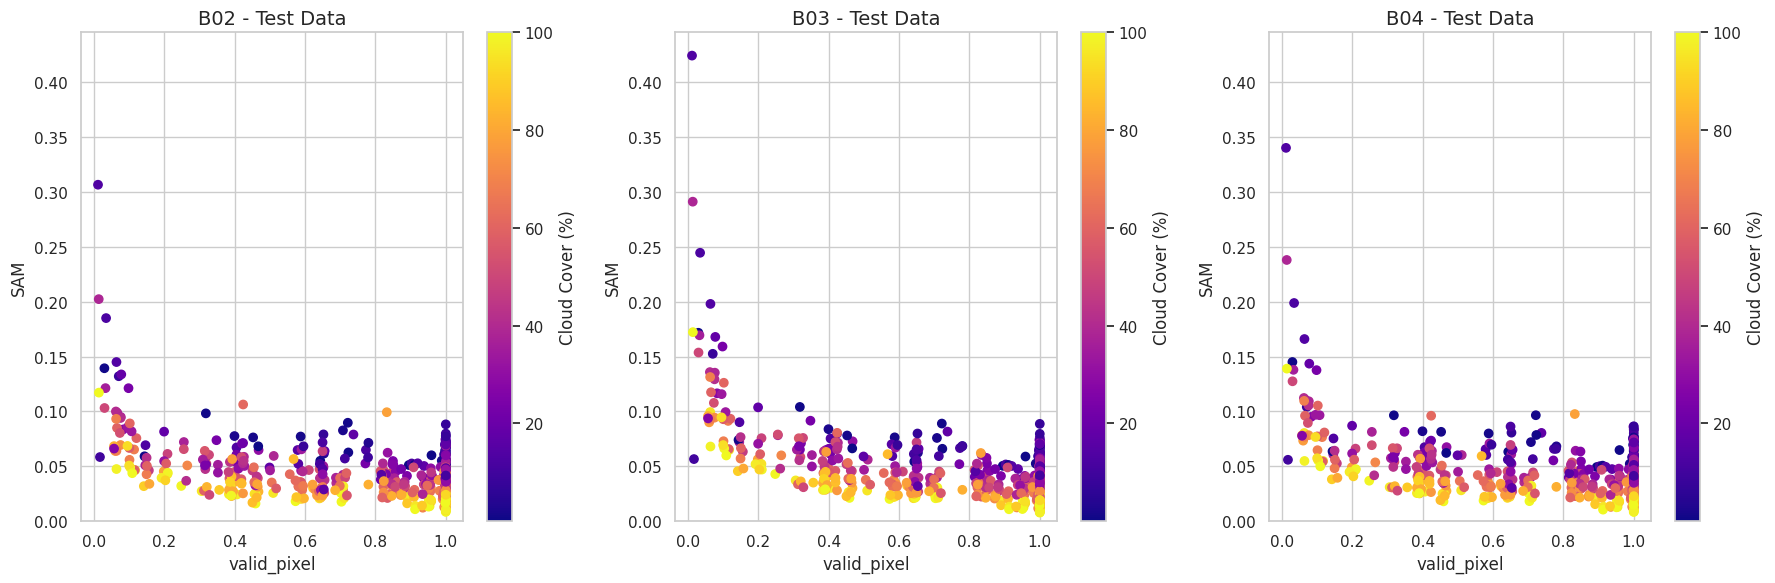

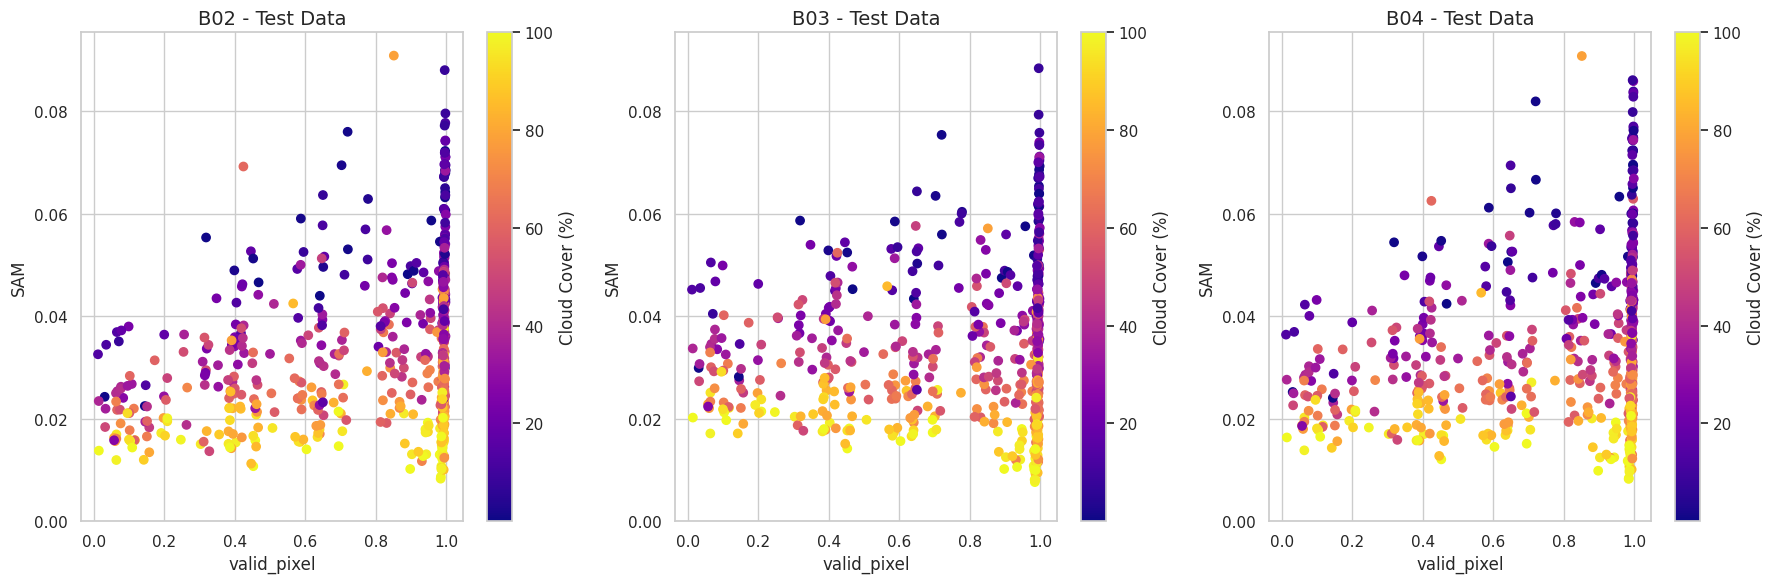

In [209]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import cm

def plot_sam_vs_cloud_cover(df_test_output, bands, mertrics_dir):
    """
    Plot SAM vs Cloud Cover for multiple bands.

    Parameters:
    df_test_output (pd.DataFrame): DataFrame containing test output data.
    bands (list): List of band names.
    mertrics_dir (str): Directory path to save the plot.

    Returns:
    None
    """
    # Set seaborn style
    sns.set(style="whitegrid")

    # Set up the figure (1 row x len(bands) columns)
    fig, axs = plt.subplots(1, len(bands), figsize=(18, 6))

    # Define the colormap
    cmap = cm.plasma

    # Find the global y-max to set consistent y-axis limits
    global_ymax = 0
    for band in bands:
        band_ymax = df_test_output[f'sam_{band}'].max()
        global_ymax = max(global_ymax, band_ymax)

    # Add a small buffer (5%) for better visualization
    global_ymax = global_ymax * 1.05

    for i, band in enumerate(bands):
        ax = axs[i]  # Single row, len(bands) columns
        # Scatter plot for SAM with plasma colormap
        scatter = ax.scatter(
            data=df_test_output,
            x='valid_pixel',
            y=f'sam_{band}',
            c=df_test_output['cloud_cover'],  # Color by cloud_cover
            cmap=cmap  # Apply the plasma colormap
        )

        # Set title and labels
        ax.set_title(f"{band} - Test Data", fontsize=14)
        ax.set_xlabel("valid_pixel", fontsize=12)
        ax.set_ylabel("SAM", fontsize=12)
        ax.set_ylim(0, global_ymax)
        # Add colorbar
        plt.colorbar(scatter, ax=ax, label="Cloud Cover (%)")

    plt.tight_layout()
    # plt.savefig(f"{mertrics_dir}/sam_vs_cloud_cover.svg")
    plt.show()
    plt.close()


plot_sam_vs_cloud_cover(df_test_output, bands, mertrics_dir)

plot_sam_vs_cloud_cover(df_test_output_w, bands, mertrics_dir)

## Plot SAM vs % Valid Pixel

In [129]:
test_metrics_tracker = MultiSpectralMetrics(bands=bands, device=device)

# Prepare the dictionary to store per-band metrics
metrics_dict = {}
for band in test_metrics_tracker.bands:
    for metric_name in ['psnr', 'rmse', 'ssim', 'sam']:
        metrics_dict[f"{metric_name}_{band}"] = []

# Reset tracker
test_metrics_tracker.reset()

# Model evaluation
model.eval()
with torch.no_grad():
    with tqdm(total=len(test_loader.dataset), ncols=100, colour='#cc99ff') as t:

        for x_data, y_data in test_loader:
            x_data, y_data = x_data.to(device), y_data.to(device)
            outputs = model(x_data)
            # Reset tracker for individual image
            test_metrics_tracker.reset()
            test_metrics_tracker.update(outputs, y_data)
            metrics = test_metrics_tracker.compute()
            # Store per-band metrics
            for band in test_metrics_tracker.bands:
                for metric_name in ['psnr', 'rmse', 'ssim', 'sam']:
                    value = metrics[band][metric_name]
                    metrics_dict[f"{metric_name}_{band}"].append(value)

            t.update(x_data.size(0))

# After the loop, merge the metrics into the original dataframe
for column_name, values in metrics_dict.items():
    df_test_output[column_name] = values

# df_test_output.to_csv(f"{exp_dir}/{experience}/test_metrics_output.csv", index=False)

100%|███████████████████████████████████████████████████████████████| 16/16 [00:03<00:00,  4.65it/s]


In [211]:
# Find index where SSIM is minimum
min_ssim_idx = df_test_output[f'ssim_{band}'].idxmin()

# Find index where SAM is maximum
max_sam_idx = df_test_output[f'sam_{band}'].idxmax()

# Get the rows corresponding to these indices
min_ssim_row = df_test_output.loc[min_ssim_idx]
max_sam_row = df_test_output.loc[max_sam_idx]

# Print results
print(f"Index of minimum SSIM for {band}: {min_ssim_idx}, SSIM value: {min_ssim_row[f'ssim_{band}']}")
print(f"Index of maximum SAM for {band}: {max_sam_idx}, SAM value: {max_sam_row[f'sam_{band}']}")

Index of minimum SSIM for B04: 560, SSIM value: 0.5515009164810181
Index of maximum SAM for B04: 560, SAM value: 0.34029099345207214


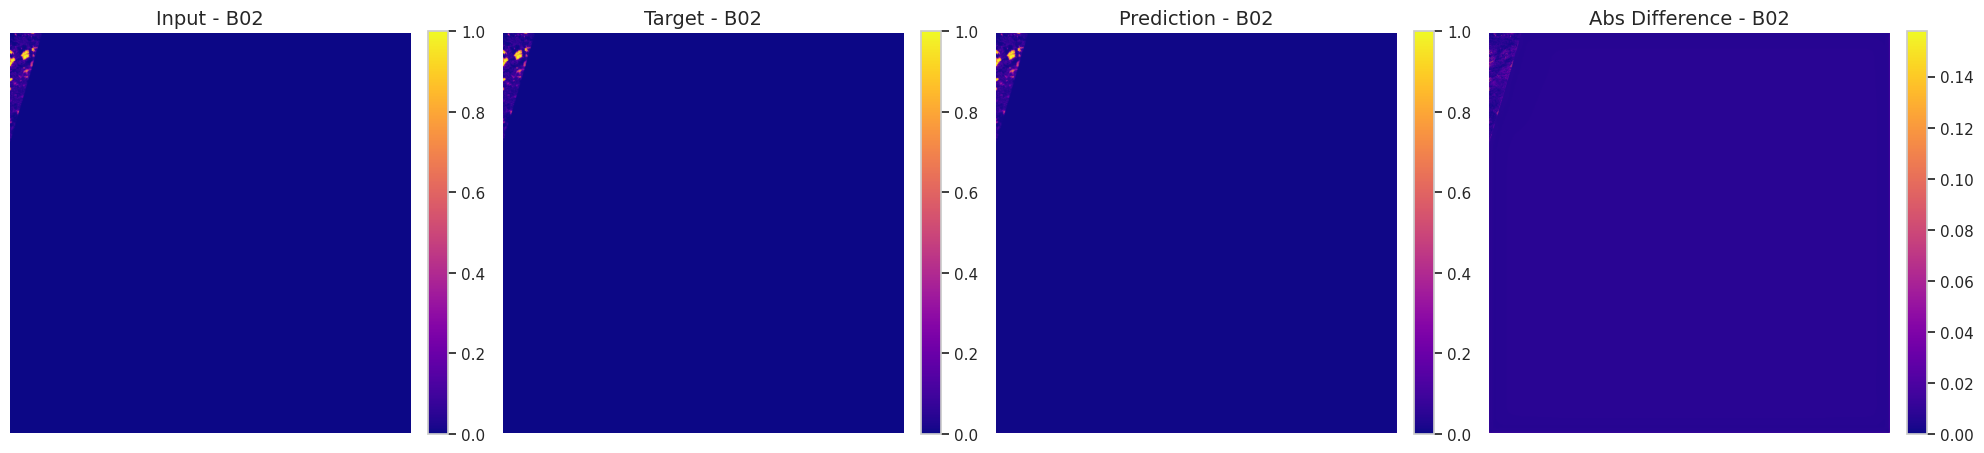

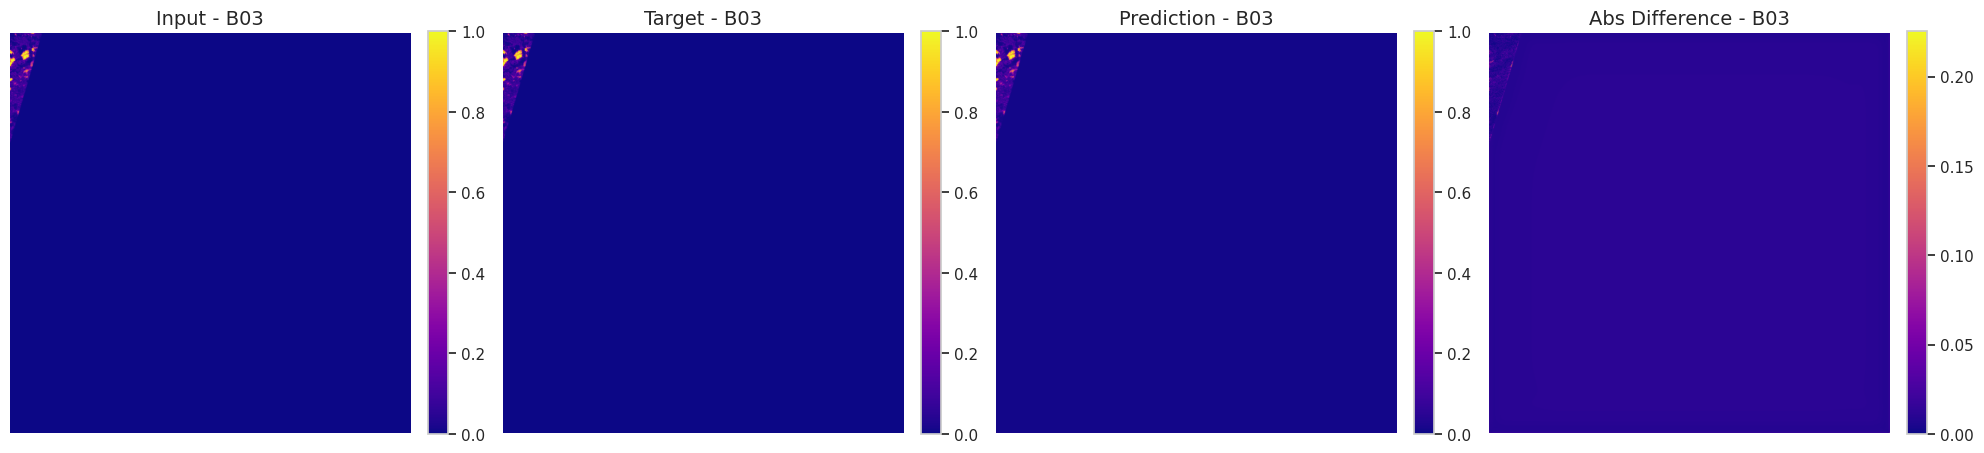

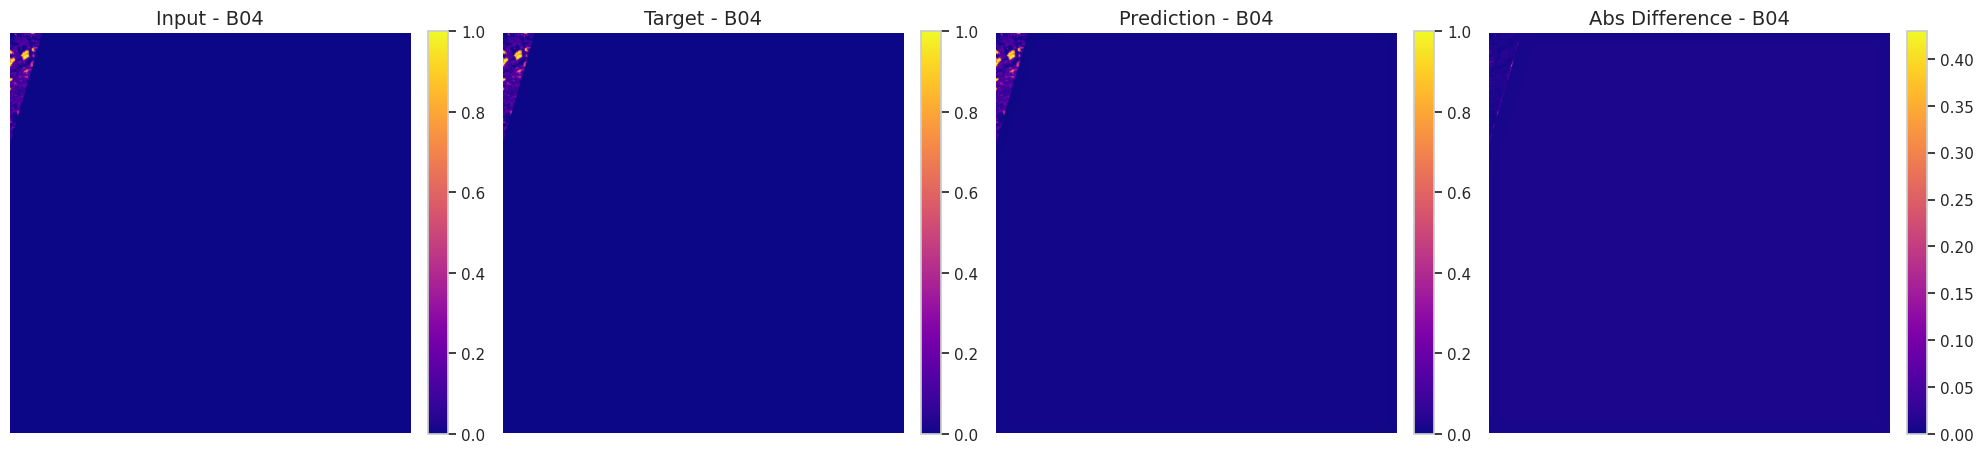

In [212]:
evaluate_and_plot(model, df_test_input, df_test_output, bands=bands, resize=resize, device=device, index=min_ssim_idx, verbose=True, save=False, output_path=output_path)

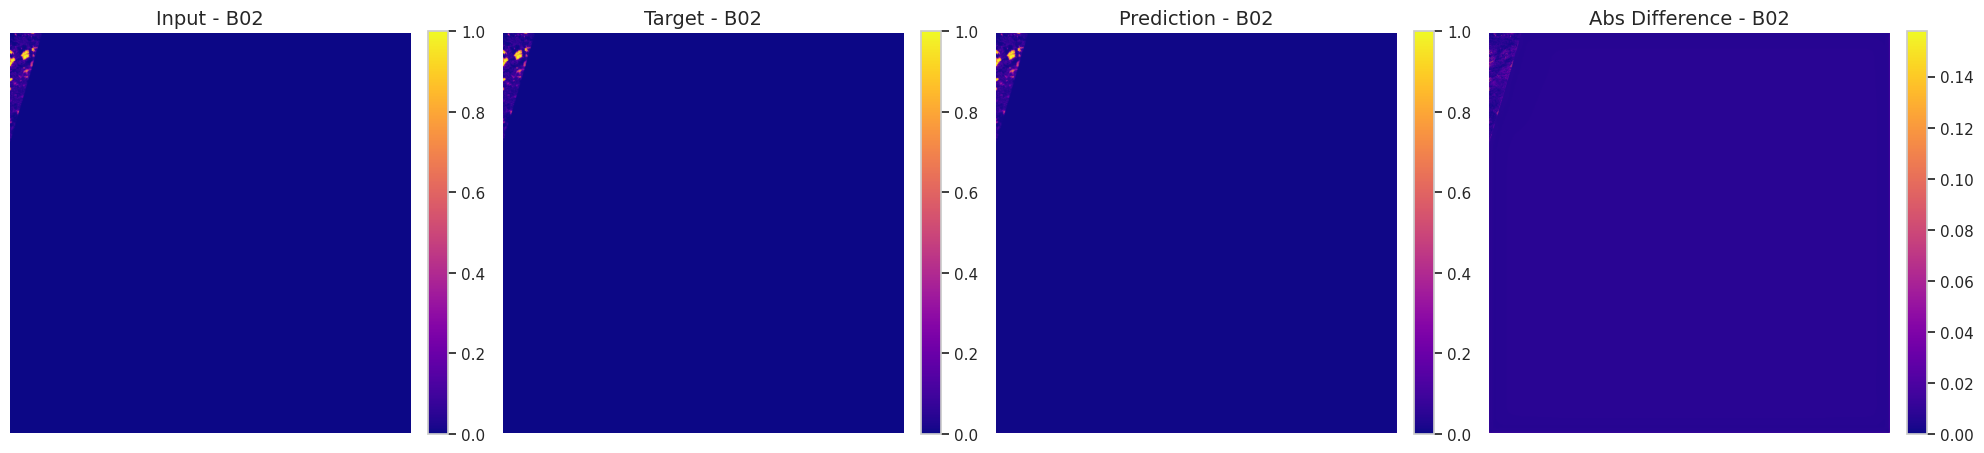

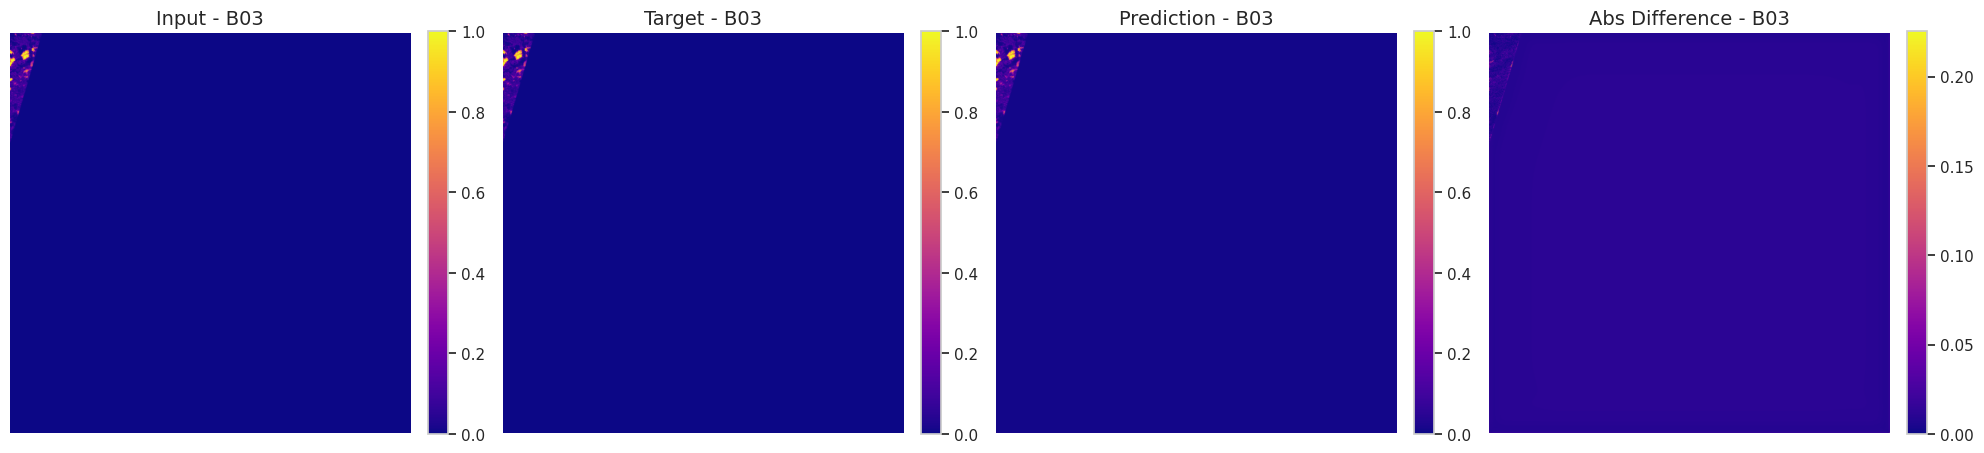

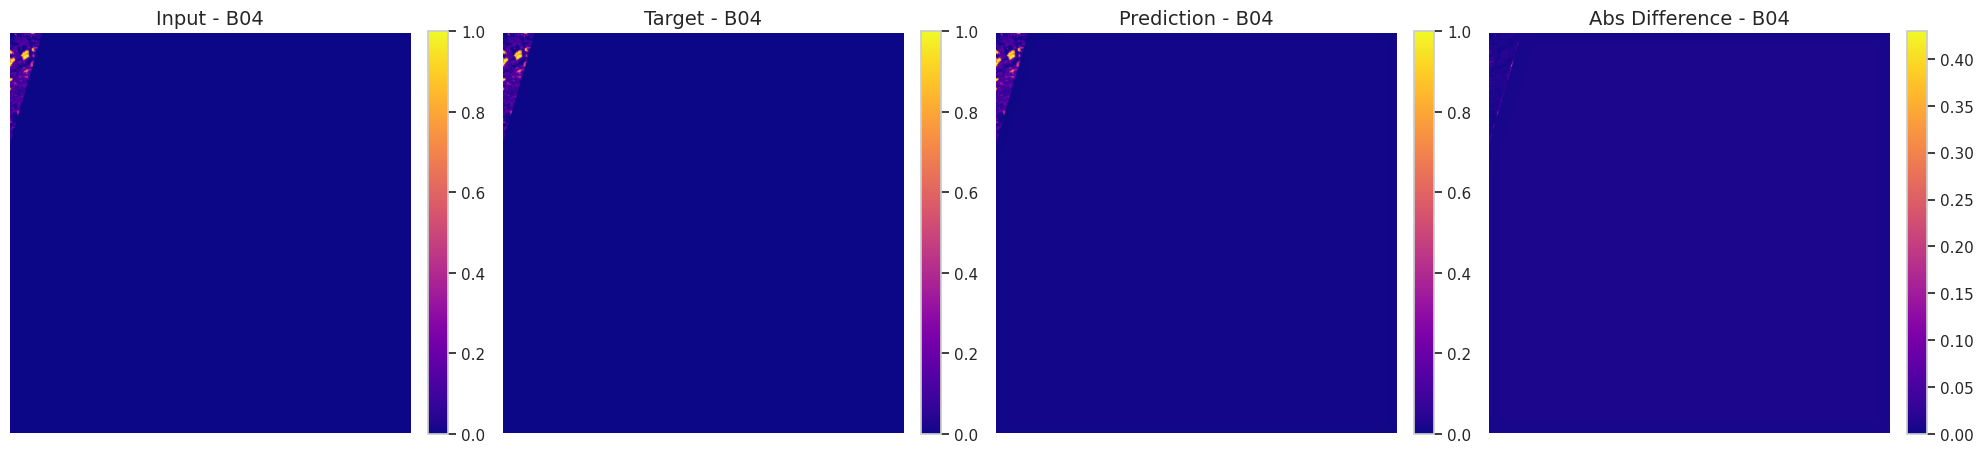

In [213]:
evaluate_and_plot(model, df_test_input, df_test_output, bands=bands, resize=resize, device=device, index=max_sam_idx, verbose=True, save=True, output_path=output_path)

In [230]:
top_10_min_ssim_idx = df_test_output_w.sort_values(f'ssim_B02').head(10).index.tolist()
top_10_max_sam_idx = df_test_output_w.sort_values(f'sam_B02', ascending=False).head(10).index.tolist()

print(f"Top 10 indices with minimum SSIM for B02: {top_10_min_ssim_idx}")
print(f"Top 10 indices with maximum SAM for B02: {top_10_max_sam_idx}")


outputs_worst_path = f"{exp_dir}/{experience}/outputs_worst"
if not os.path.exists(outputs_worst_path):
    os.makedirs(outputs_worst_path)

Top 10 indices with minimum SSIM for B02: [560, 81, 536, 48, 290, 459, 339, 268, 596, 178]
Top 10 indices with maximum SAM for B02: [436, 317, 16, 350, 562, 15, 216, 227, 250, 470]


In [231]:
for idx in top_10_max_sam_idx:
    evaluate_and_plot(model, df_test_input, df_test_output_w, bands=bands, resize=resize, device=device, index=idx, verbose=False, save=True, output_path=outputs_worst_path)

In [232]:
top_10_max_ssim_idx = df_test_output_w.sort_values(f'ssim_B02').tail(20).index.tolist()
top_10_min_sam_idx = df_test_output_w.sort_values(f'sam_B02', ascending=False).tail(20).index.tolist()

print(f"Top 10 indices with maximum SSIM for B02: {top_10_max_ssim_idx}")
print(f"Top 10 indices with minimum SAM for B02: {top_10_min_sam_idx}")


output_best_path = f"{exp_dir}/{experience}/outputs_best"
if not os.path.exists(output_best_path):
    os.makedirs(output_best_path)

Top 10 indices with maximum SSIM for B02: [291, 8, 444, 540, 274, 19, 115, 4, 440, 122, 18, 514, 581, 124, 236, 214, 24, 413, 520, 371]
Top 10 indices with minimum SAM for B02: [129, 371, 433, 291, 489, 188, 236, 171, 120, 314, 201, 19, 121, 112, 520, 419, 567, 380, 18, 214]


In [233]:
for idx in top_10_min_sam_idx:
    evaluate_and_plot(model, df_test_input, df_test_output_w, bands=bands, resize=resize, device=device, index=idx, verbose=False, save=True, output_path=output_best_path)

In [234]:
top_10_min_ssim_idx = df_test_output.sort_values(f'ssim_B02').head(10).index.tolist()
top_10_max_sam_idx = df_test_output.sort_values(f'sam_B02', ascending=False).head(10).index.tolist()

print(f"Top 10 indices with minimum SSIM for B02: {top_10_min_ssim_idx}")
print(f"Top 10 indices with maximum SAM for B02: {top_10_max_sam_idx}")


outputs_worst_path = f"{exp_dir}/{experience}/outputs_worst_0"
if not os.path.exists(outputs_worst_path):
    os.makedirs(outputs_worst_path)

Top 10 indices with minimum SSIM for B02: [560, 81, 536, 48, 290, 459, 339, 268, 596, 178]
Top 10 indices with maximum SAM for B02: [560, 81, 339, 22, 48, 391, 45, 459, 20, 536]


In [235]:
for idx in top_10_max_sam_idx:
    evaluate_and_plot(model, df_test_input, df_test_output, bands=bands, resize=resize, device=device, index=idx, verbose=False, save=True, output_path=outputs_worst_path)